## Lets predict the mobility of countries in times of COVID-19.
In recent years, mobility of each country has seen drastic changes due to COVID-19. Let us predict the factors that affect mobility the most. Every country have different variables (e.g. population density, vaccination rate). How can we group country that are similar together? By doing so, can we improve the prediction accuracy?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as plt
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

## Data preparation
- Load CSV
- Drop irrelavant data (e.g. 'World' in continent, and 'tests_units' string column)
- Drop empty rows
- Merge COVID-19 data with mobility data

In [2]:
# Load data
general_data = pd.read_csv("owid-covid-data.csv")
mobility_data = pd.read_csv("changes-visitors-covid.csv")
print(general_data.shape, mobility_data.shape)

# Clean null columns in 'continent
# Data have non-country values under location (e.g. World, Asia)
# Remove 'tests_units' string column
general_data = general_data.dropna(subset=['continent'])
general_data = general_data.drop('tests_units', axis=1)
mobility_data = mobility_data.dropna()
print(general_data.shape, mobility_data.shape)

(169077, 67) (99336, 9)
(158965, 66) (96433, 9)


In [3]:
# general_data_clean = general_data[keep_columns]
# general_data_clean = general_data_clean.dropna()
general_data_clean = general_data
general_data_clean.shape

(158965, 66)

In [4]:
merged_data = pd.merge(general_data_clean, mobility_data, left_on=['iso_code','location','date'], right_on = ['Code','Entity','Day'])
merged_data = merged_data.drop(['Entity', 'Code', 'Day'], axis=1)
merged_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


## Average mobility across all country
- Get list of countries
- Barplot mean mobility for each country

In [5]:
countries = merged_data.drop_duplicates(subset = ["location"])[['location']].values.flatten().tolist()
print(countries)

['Afghanistan', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Chile', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North

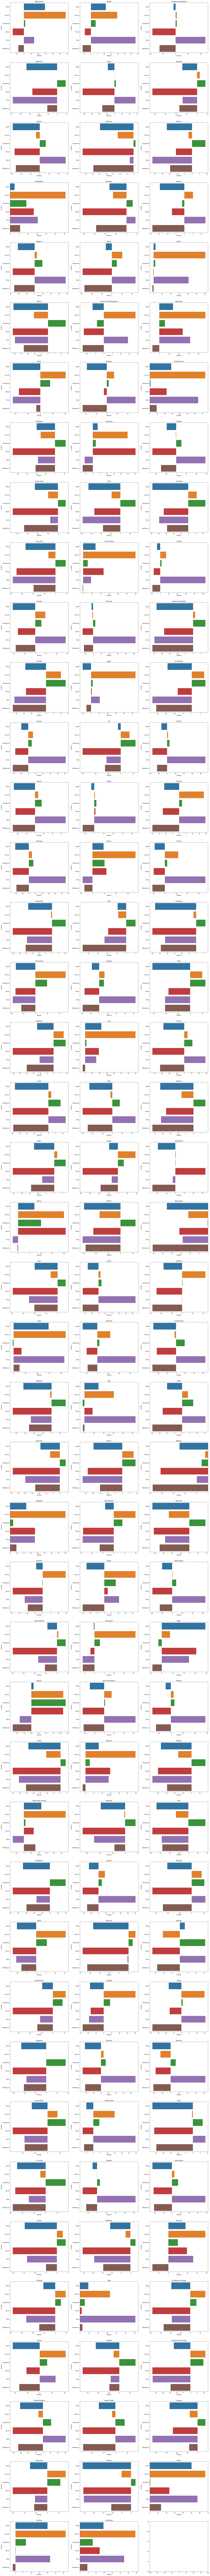

In [6]:
graph_per_row = 3
row = int(len(countries)/graph_per_row)+1
f, axes = plt.subplots(row, graph_per_row, figsize=(30, 400))
plt.xlim(-100, 100)

i = 0
for c in countries:
    country_data = merged_data.loc[merged_data['location'] == c]
    retail = country_data['retail_and_recreation'].mean()
    grocery = country_data['grocery_and_pharmacy'].mean()
    residential = country_data['residential'].mean()
    transit = country_data['transit_stations'].mean()
    parks = country_data['parks'].mean()
    workplaces = country_data['workplaces'].mean()
    mobility_location = pd.DataFrame({'Location':['Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces'], 
                                    'Mobility':[retail, grocery, residential, transit, parks, workplaces]})
    sb.barplot(x='Mobility',y='Location',data=mobility_location, ax = axes[i//graph_per_row,i%graph_per_row], orient='h').set_title(c)
    i+=1

As we can see the average mobility differs across each country. How can we group country that are similar together?

## K-Means clustering for countries by country's development
- Get latest data for each country
- EDA for PCA & K-Means
- Assign a cluster to every country

In [7]:
# Grab column that is needed for classification
cluster_data = pd.DataFrame(merged_data[["location", "date", "population_density", "gdp_per_capita", "life_expectancy", "human_development_index"]])
cluster_data = cluster_data.dropna()
cluster_data.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index
0,Afghanistan,2020-02-24,54.422,1803.987,64.83,0.511
1,Afghanistan,2020-02-25,54.422,1803.987,64.83,0.511
2,Afghanistan,2020-02-26,54.422,1803.987,64.83,0.511
3,Afghanistan,2020-02-27,54.422,1803.987,64.83,0.511
4,Afghanistan,2020-02-28,54.422,1803.987,64.83,0.511


In [8]:
# Grab the latest data by sorting first then keeping the last data for each location
cluster_data = cluster_data.sort_values(by=['date']).drop_duplicates(subset='location', keep='last')

# Reset index for ease in combination of data later on
cluster_data.reset_index(drop=True, inplace=True)
cluster_data.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704
1,Niger,2022-03-12,16.955,926.000,62.42,0.394
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646
4,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944


In [9]:
# Drop location & date in prepation for classification
kmean_data = cluster_data.drop(columns=['location' ,'date'])
kmean_data.head()

,population_density,gdp_per_capita,life_expectancy,human_development_index
0,308.127,6171.884,75.40,0.704
1,16.955,926.000,62.42,0.394
2,204.430,2442.804,70.78,0.602
3,3.078,9541.808,63.71,0.646
4,508.544,48472.545,82.28,0.944


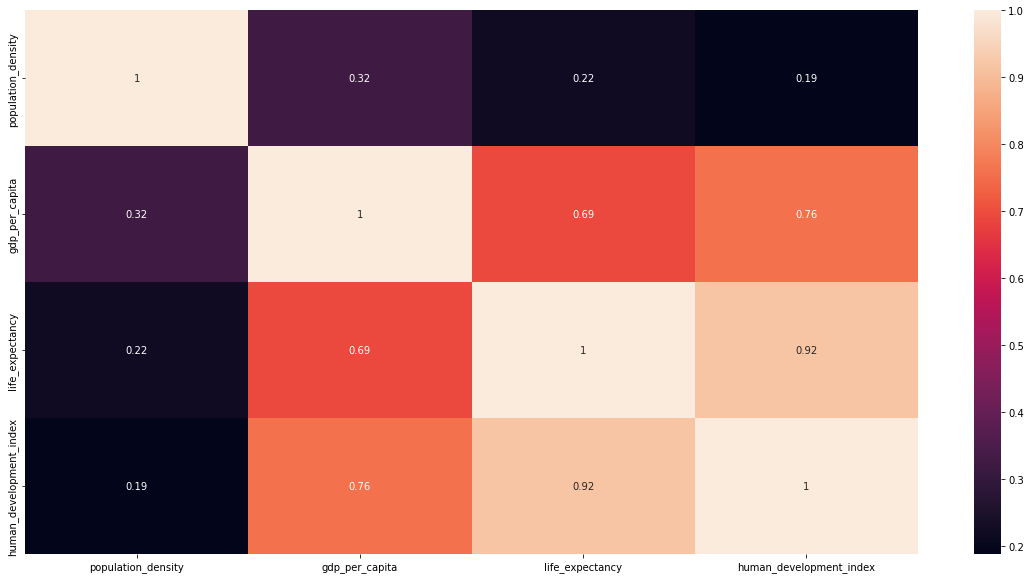

In [10]:
# Analysis for K-Means Clustering
# Plot heatmap to show correlation across data
plt.figure(figsize = (20,10))
sb.heatmap(kmean_data.corr(),annot = True)
plt.show()

In [11]:
# Scale variables to a common value
s_scaler = StandardScaler()
kmean_data_scaled = s_scaler.fit_transform(kmean_data)
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(kmean_data_scaled)
pca.components_

array([[ 0.24164155,  0.53760095,  0.56591608,  0.5764838 ],
       [ 0.95345292,  0.0219156 , -0.19287339, -0.2307533 ],
       [-0.17156409,  0.82837606, -0.4826024 , -0.22683429],
       [-0.05570143,  0.15587824,  0.64002639, -0.7503103 ]])

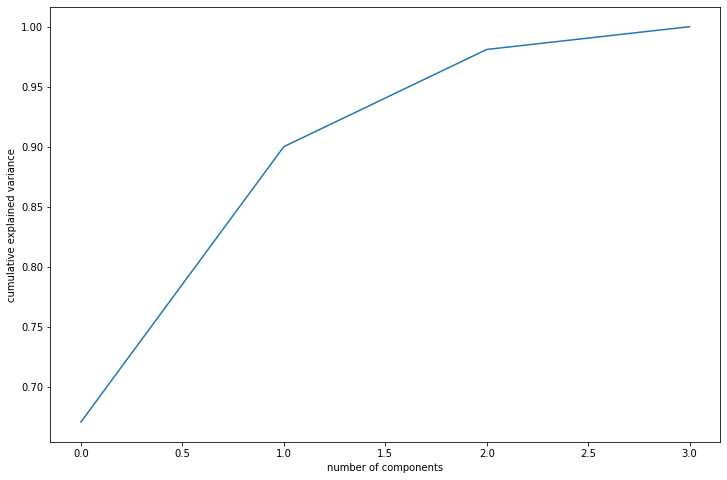

In [12]:
# Plot variance ratio 
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [13]:
# Plot PC values for each variable
colnames = list(kmean_data.columns)
pcs_df = pd.DataFrame({'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1]})
pcs_df

,Feature,PC1,PC2
0,population_density,0.241642,0.953453
1,gdp_per_capita,0.537601,0.021916
2,life_expectancy,0.565916,-0.192873
3,human_development_index,0.576484,-0.230753


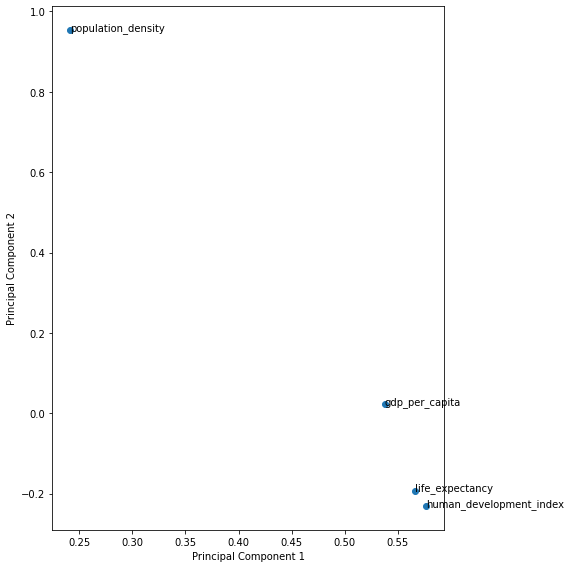

In [14]:
# Plot correlation of PC
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [15]:
# Scale variables according to analysis
pca_final = IncrementalPCA(n_components=2)
df_pca = pca_final.fit_transform(kmean_data_scaled)
df_pca.shape

(126, 2)

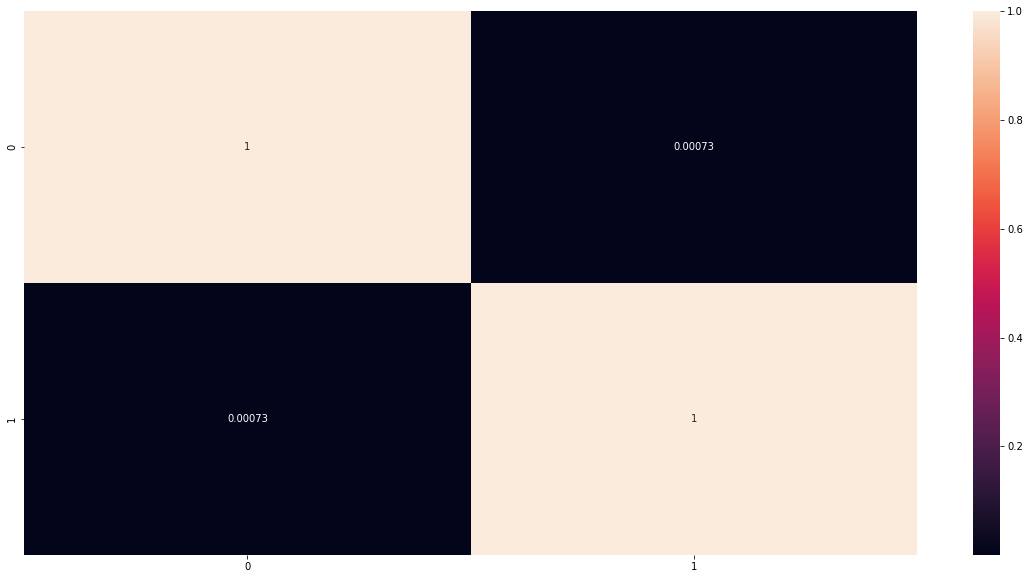

In [16]:
# Plot correlation of PCs
pc = np.transpose(df_pca)
corrmat = np.corrcoef(pc)
plt.figure(figsize=(20,10))
sb.heatmap(corrmat,annot=True)
plt.show()

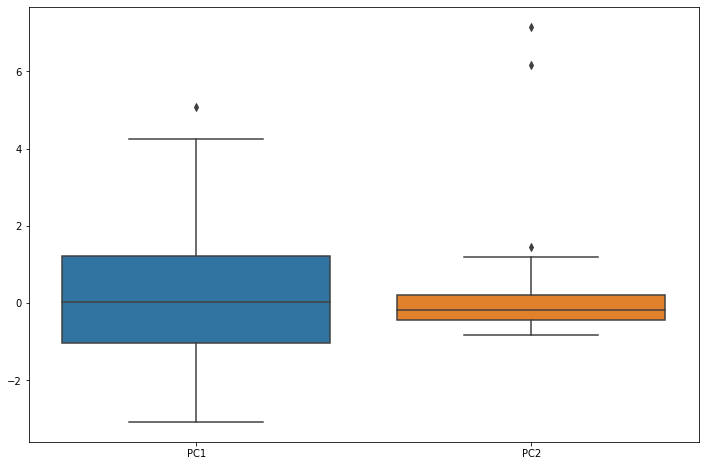

In [17]:
# Boxplot of PCs and outliers
pcs_df2 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1]})
fig = plt.figure(figsize = (12,8))
sb.boxplot(data=pcs_df2)
plt.show()

In [18]:
pcs_df2.shape

(126, 2)

In [19]:
pcs_df2.head()

,PC1,PC2
0,-0.504470,0.041070
1,-3.019560,0.634132
2,-1.414386,0.234534
3,-1.675776,0.184459
4,2.173764,-0.271062


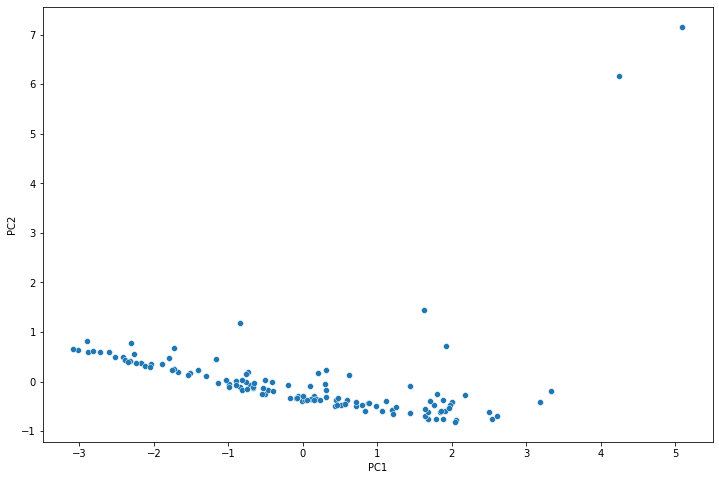

In [20]:
# Plot spread of data
fig = plt.figure(figsize = (12,8))
sb.scatterplot(x='PC1',y='PC2',data=pcs_df2)
plt.show()

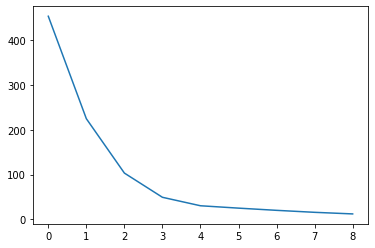

In [21]:
# Elbow plot for the most optimum number of K-Means clusters
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(pcs_df2)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.show()

In [22]:
# Fit K-Means clustering
model_clus2 = KMeans(n_clusters = 2, max_iter=50,random_state = 50)
model_clus2.fit(pcs_df2)

KMeans(max_iter=50, n_clusters=2, random_state=50)

In [23]:
# Cluster data accordingly
dat4=pcs_df2
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
dat_km.columns = ['PC1','PC2','ClusterID']
dat_km

,PC1,PC2,ClusterID
0,-0.504470,0.041070,1
1,-3.019560,0.634132,1
2,-1.414386,0.234534,1
3,-1.675776,0.184459,1
4,2.173764,-0.271062,0
...,...,...,...
121,-2.318970,0.409282,1
122,1.642309,-0.550550,0
123,-0.416415,-0.017917,1
124,-2.597272,0.602423,1


In [24]:
dat_km['ClusterID'].value_counts()

0    70
1    56
Name: ClusterID, dtype: int64

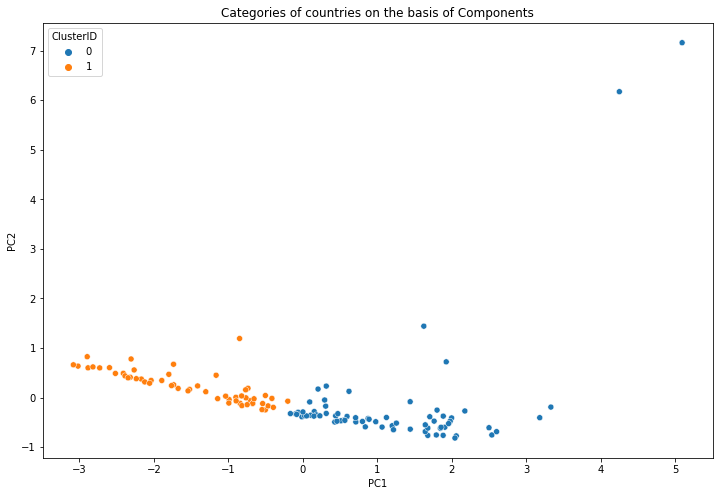

In [25]:
# Plot cluster of data
fig = plt.figure(figsize = (12,8))
sb.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

plt.title('Categories of countries on the basis of Components')
plt.show()

In [26]:
# Merge location with clustering data
dat5=pd.merge(cluster_data,dat_km, left_index=True,right_index=True)
dat5.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704,-0.504470,0.041070,1
1,Niger,2022-03-12,16.955,926.000,62.42,0.394,-3.019560,0.634132,1
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602,-1.414386,0.234534,1
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646,-1.675776,0.184459,1
4,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944,2.173764,-0.271062,0


In [27]:
# Split data according to clusters
cluster1 = dat5[dat5["ClusterID"]==0]
cluster1.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID
4,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944,2.173764,-0.271062,0
5,New Zealand,2022-03-12,18.206,36085.843,82.29,0.931,1.676248,-0.764135,0
8,Antigua and Barbuda,2022-03-12,231.845,21490.943,77.02,0.778,0.305033,-0.173354,0
9,North Macedonia,2022-03-12,82.600,13111.214,75.80,0.774,-0.065551,-0.296724,0
10,Thailand,2022-03-12,135.132,16277.671,77.15,0.777,0.151579,-0.282644,0


In [28]:
# Split data according to clusters
cluster2 = dat5[dat5["ClusterID"]==1]
cluster2.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704,-0.504470,0.041070,1
1,Niger,2022-03-12,16.955,926.000,62.42,0.394,-3.019560,0.634132,1
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602,-1.414386,0.234534,1
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646,-1.675776,0.184459,1
6,Nicaragua,2022-03-12,51.667,5321.444,74.48,0.660,-0.843727,-0.116647,1


## Finding correlation for data
- Plot correlation matrix for all data
- Find the most relevant variables

In [29]:
corr = merged_data.corr()
with pd.option_context('display.precision', 2):
    style = corr.style.background_gradient(cmap='coolwarm').format(precision=2)
style

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
total_cases,1.00,0.61,0.65,0.92,0.57,0.61,0.27,0.11,0.13,0.27,0.07,0.09,-0.02,0.73,0.14,0.73,0.05,0.42,0.02,0.75,0.17,0.93,0.76,0.11,0.04,0.76,0.05,0.02,-0.03,0.75,0.72,0.72,0.78,0.56,0.62,0.15,0.17,0.12,0.11,0.06,0.52,0.01,0.04,0.50,-0.03,0.09,0.09,0.09,0.08,-0.07,-0.10,0.05,0.08,-0.07,0.05,-0.02,0.09,0.11,0.82,0.12,0.02,0.21,0.00,0.05,0.00,0.03,0.00,0.03
new_cases,0.61,1.00,0.94,0.52,0.59,0.57,0.23,0.35,0.31,0.17,0.12,0.12,0.05,0.63,0.17,0.72,0.12,0.41,0.13,0.72,0.32,0.56,0.65,0.11,0.10,0.64,0.11,0.15,-0.04,0.35,0.31,0.34,0.64,0.25,0.28,0.16,0.13,0.12,0.22,0.04,0.24,-0.02,0.06,0.31,-0.02,0.10,0.11,0.11,0.09,-0.07,-0.10,0.02,0.09,-0.03,0.05,0.03,0.10,0.12,0.47,0.07,0.07,0.11,-0.05,-0.01,0.05,-0.04,-0.04,-0.04
new_cases_smoothed,0.65,0.94,1.00,0.56,0.60,0.63,0.24,0.29,0.33,0.18,0.12,0.13,0.03,0.68,0.19,0.78,0.14,0.46,0.14,0.79,0.35,0.59,0.67,0.11,0.09,0.68,0.11,0.16,-0.04,0.38,0.33,0.36,0.70,0.25,0.30,0.16,0.13,0.12,0.24,0.04,0.25,-0.02,0.06,0.33,-0.02,0.11,0.12,0.11,0.09,-0.07,-0.10,0.02,0.09,-0.03,0.05,0.03,0.10,0.12,0.52,0.05,0.05,0.11,-0.06,-0.01,0.06,-0.04,-0.04,-0.04
total_deaths,0.92,0.52,0.56,1.00,0.60,0.65,0.22,0.06,0.06,0.38,0.11,0.13,-0.01,0.78,0.16,0.76,0.05,0.48,-0.00,0.77,0.14,0.82,0.71,0.05,0.01,0.66,0.00,0.04,-0.04,0.66,0.64,0.65,0.66,0.52,0.58,0.10,0.14,0.07,0.00,0.08,0.49,0.04,0.05,0.46,-0.05,0.09,0.08,0.08,0.06,-0.10,-0.13,0.05,0.06,-0.08,0.11,-0.04,0.10,0.11,0.95,0.32,0.10,0.36,-0.01,0.04,0.01,0.02,-0.01,0.05
new_deaths,0.57,0.59,0.60,0.60,1.00,0.94,0.09,0.07,0.07,0.17,0.31,0.30,-0.02,0.86,0.30,0.86,0.19,0.70,0.35,0.84,0.31,0.45,0.59,-0.02,-0.01,0.56,-0.01,0.14,-0.05,0.28,0.27,0.25,0.54,0.32,0.34,-0.08,-0.07,-0.11,0.01,0.01,0.35,0.04,0.14,0.42,-0.04,0.08,0.07,0.07,0.05,-0.08,-0.10,0.04,0.05,-0.05,0.09,-0.03,0.08,0.10,0.46,0.29,0.40,0.16,-0.14,-0.07,0.13,-0.10,-0.11,-0.09
new_deaths_smoothed,0.61,0.57,0.63,0.65,0.94,1.00,0.09,0.06,0.07,0.19,0.26,0.32,-0.03,0.92,0.33,0.92,0.20,0.78,0.38,0.90,0.33,0.48,0.59,-0.02,-0.01,0.59,-0.01,0.14,-0.05,0.30,0.29,0.27,0.61,0.32,0.36,-0.08,-0.08,-0.11,0.01,0.02,0.37,0.05,0.15,0.44,-0.04,0.08,0.08,0.07,0.05,-0.09,-0.10,0.05,0.06,-0.05,0.09,-0.03,0.08,0.10,0.66,0.24,0.32,0.17,-0.15,-0.07,0.14,-0.11,-0.12,-0.09
total_cases_per_million,0.27,0.23,0.24,0.22,0.09,0.09,1.00,0.57,0.66,0.70,0.28,0.34,-0.03,0.08,0.21,0.11,0.26,-0.02,0.04,0.12,0.28,0.24,0.18,0.61,0.36,0.19,0.41,0.27,-0.07,0.03,-0.01,0.02,0.25,-0.08,-0.04,0.55,0.48,0.49,0.59,0.10,-0.07,-0.08,-0.13,-0.07,-0.03,0.35,0.33,0.32,0.27,-0.30,-0.13,0.03,0.35,0.07,0.34,0.20,0.32,0.37,0.17,0.19,0.05,0.51,0.10,0.

In [30]:
relevant_columns = ['icu_patients_per_million', 'hosp_patients', 'total_cases', 'people_fully_vaccinated', 
                    'new_cases', 'aged_70_older', 'retail_and_recreation', 'grocery_and_pharmacy', 'residential', 
                    'transit_stations', 'parks', 'workplaces']

The most relevant data against mobility are
['icu_patients_per_million', 'hosp_patients', 'total_cases', 'people_fully_vaccinated', 'new_cases', 'aged_70_older']

## ICU patients among clusters

In [31]:
cluster1_icu = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_icu.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,ATG,North America,Antigua and Barbuda,2020-03-13,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.429,8.286,0.500,-0.286,4.000,3.714
1,ATG,North America,Antigua and Barbuda,2020-03-14,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.286,7.714,1.167,-2.571,2.714,2.857
2,ATG,North America,Antigua and Barbuda,2020-03-15,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,ATG,North America,Antigua and Barbuda,2020-03-16,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,ATG,North America,Antigua and Barbuda,2020-03-17,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.429,4.286,4.167,-8.000,-4.286,-3.429


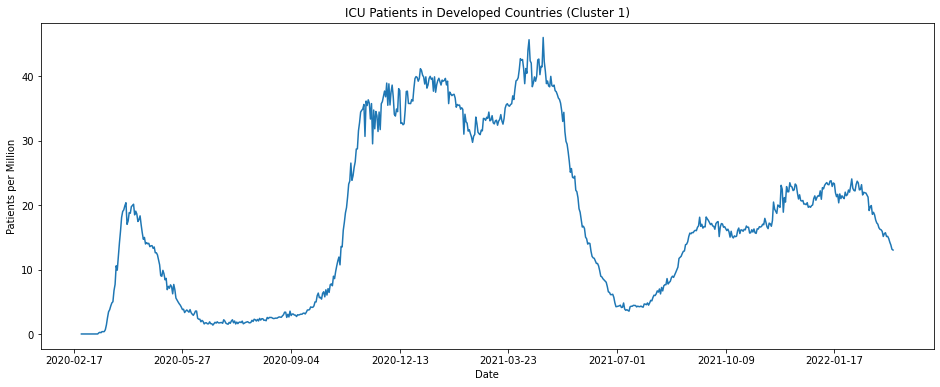

In [32]:
cluster1_icu_g = pd.DataFrame(data = cluster1_icu[["icu_patients_per_million"]].groupby(cluster1_icu["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_icu_g["icu_patients_per_million"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Patients per Million")
plt.title("ICU Patients in Developed Countries (Cluster 1)");

In [33]:
cluster2_icu = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_icu.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


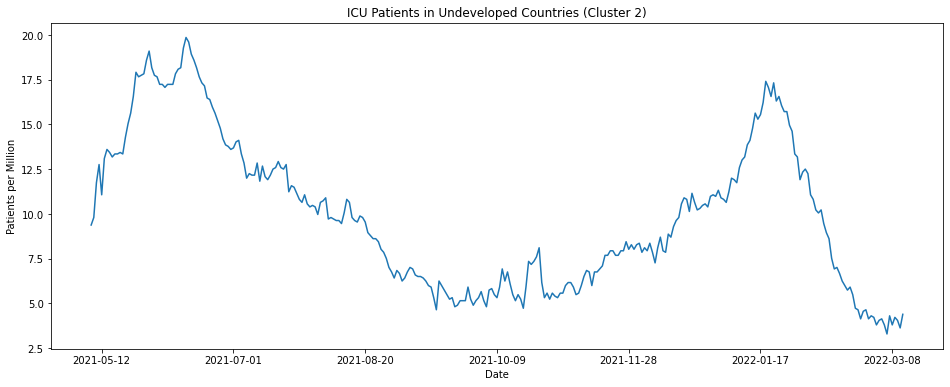

In [34]:
cluster2_icu_g = pd.DataFrame(data = cluster2_icu[["icu_patients_per_million"]].groupby(cluster2_icu["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_icu_g["icu_patients_per_million"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Patients per Million")
plt.title("ICU Patients in Undeveloped Countries (Cluster 2)");

In [35]:
cluster1_icu.describe()[['icu_patients_per_million']]

,icu_patients_per_million
count,22055.000000
mean,24.947445
std,28.530440
min,0.000000
25%,4.422500
50%,14.192000
75%,36.063000
max,177.282000


In [36]:
cluster2_icu.describe()[['icu_patients_per_million']]

,icu_patients_per_million
count,309.000000
mean,9.986126
std,4.178323
min,3.296000
25%,6.254000
50%,9.634000
75%,12.846000
max,19.860000


The spike of cases in ICU patients at around Jan 2022 is lower in cluster 1 compared to cluster 2. This might be due to the higher number of population that are fully vaccinated in cluster 1.

Observing the average ICU patients per cluster, cluster 1 generally have higher ICU patients but, this may be due to the higher capacity of hospital/ICU beds in developed countries compared to undeveloped countries.

## Hospital patients among clusters

In [37]:
cluster1_hospital = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_hospital.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,ATG,North America,Antigua and Barbuda,2020-03-13,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.429,8.286,0.500,-0.286,4.000,3.714
1,ATG,North America,Antigua and Barbuda,2020-03-14,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.286,7.714,1.167,-2.571,2.714,2.857
2,ATG,North America,Antigua and Barbuda,2020-03-15,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,ATG,North America,Antigua and Barbuda,2020-03-16,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,ATG,North America,Antigua and Barbuda,2020-03-17,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.429,4.286,4.167,-8.000,-4.286,-3.429


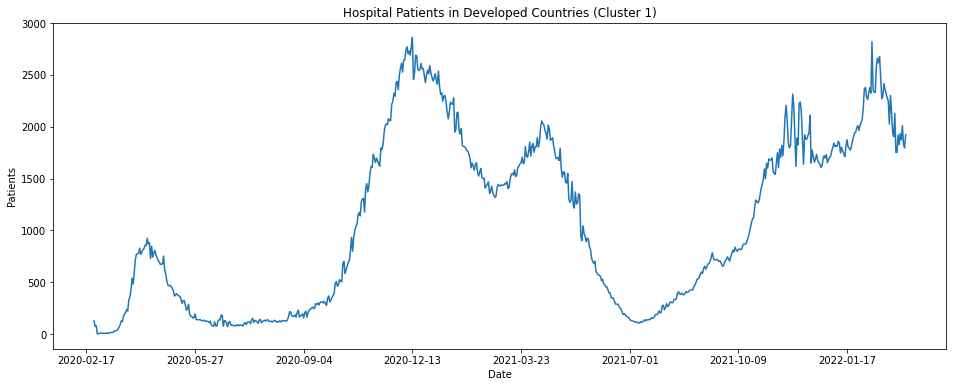

In [38]:
cluster1_hospital_g = pd.DataFrame(data = cluster1_hospital[["hosp_patients"]].groupby(cluster1_hospital["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_hospital_g["hosp_patients"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Patients")
plt.title("Hospital Patients in Developed Countries (Cluster 1)");

In [39]:
cluster2_hospital = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_hospital.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


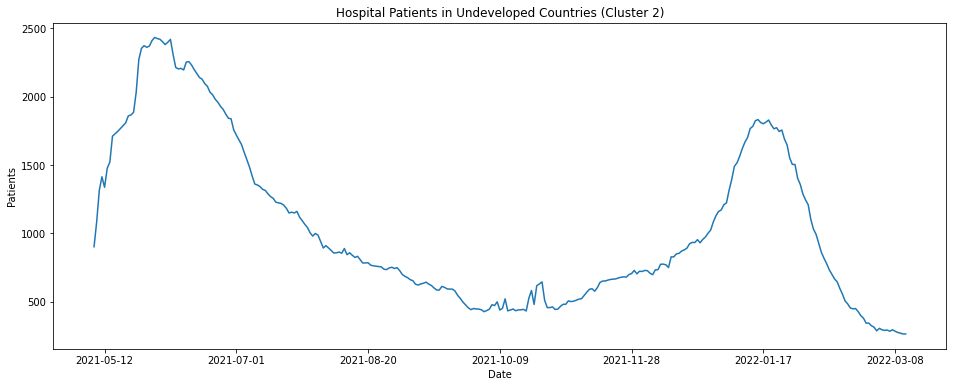

In [40]:
cluster2_hospital_g = pd.DataFrame(data = cluster2_hospital[["hosp_patients"]].groupby(cluster2_hospital["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_hospital_g["hosp_patients"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Patients")
plt.title("Hospital Patients in Undeveloped Countries (Cluster 2)");

Hospital patients in cluster 1 tends to stay high for a longer period of time. Whereas in cluster 2, hospital patients spikes and drops over a shorter period of time

## Fully vaccinated population among clusters
- Split countries into clusters
- Find number of people fully vaccinated and the country's population
- Display barplot for each cluster

In [41]:
# Grab vaccination data
vac = pd.DataFrame(merged_data[["location", "people_fully_vaccinated"]])
vac = vac.dropna()
vac.head()

,location,people_fully_vaccinated
374,Afghanistan,55624.0
383,Afghanistan,77560.0
387,Afghanistan,96910.0
389,Afghanistan,111082.0
390,Afghanistan,113739.0


In [42]:
# Get the latest poeple fully vaccinated data
vac = vac.sort_values(by=['people_fully_vaccinated']).drop_duplicates(subset='location', keep='last')
vac.head()

,location,people_fully_vaccinated
2051,Antigua and Barbuda,61327.0
3524,Aruba,80693.0
34319,Haiti,107268.0
7916,Barbados,150337.0
5727,Bahamas,155124.0


In [43]:
# Get latest population data
pop = pd.DataFrame(merged_data[["location", "population"]])
pop = pop.dropna()
pop = pop.sort_values(by=['population']).drop_duplicates(subset='location', keep='last')
pop.head()

,location,population
1388,Antigua and Barbuda,98728.0
3494,Aruba,107195.0
7466,Barbados,287708.0
5498,Bahamas,396914.0
9588,Belize,404915.0


In [44]:
# Merge people fully vaccinated and population
vac_pop = vac.merge(pop, left_on=["location"], right_on=["location"])
vac_pop.head()

,location,people_fully_vaccinated,population
0,Antigua and Barbuda,61327.0,98728.0
1,Aruba,80693.0,107195.0
2,Haiti,107268.0,11541683.0
3,Barbados,150337.0,287708.0
4,Bahamas,155124.0,396914.0


In [45]:
# Calculate the percentage of people vaccinated in across all countries
vac_pop["vac_pop_percentage"] = (vac_pop["people_fully_vaccinated"] / vac_pop["population"]) * 100
vac_pop.head()

,location,people_fully_vaccinated,population,vac_pop_percentage
0,Antigua and Barbuda,61327.0,98728.0,62.117130
1,Aruba,80693.0,107195.0,75.276832
2,Haiti,107268.0,11541683.0,0.929397
3,Barbados,150337.0,287708.0,52.253326
4,Bahamas,155124.0,396914.0,39.082522


In [46]:
# Merge data according to cluster
cluster1_pop = cluster1.merge(vac_pop, left_on=["location"], right_on=["location"])
cluster1_pop.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID,people_fully_vaccinated,population,vac_pop_percentage
0,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944,2.173764,-0.271062,0,12361264.0,17173094.0,71.980413
1,New Zealand,2022-03-12,18.206,36085.843,82.29,0.931,1.676248,-0.764135,0,3976247.0,5126300.0,77.565632
2,Antigua and Barbuda,2022-03-12,231.845,21490.943,77.02,0.778,0.305033,-0.173354,0,61327.0,98728.0,62.117130
3,North Macedonia,2022-03-12,82.600,13111.214,75.80,0.774,-0.065551,-0.296724,0,834203.0,2082661.0,40.054670
4,Thailand,2022-03-12,135.132,16277.671,77.15,0.777,0.151579,-0.282644,0,49893668.0,69950844.0,71.326756


In [47]:
cluster1_pop.describe()[["vac_pop_percentage"]]

,vac_pop_percentage
count,70.000000
mean,67.850549
std,15.673898
min,25.925866
25%,61.213572
50%,71.663849
75%,78.173257
max,95.426812


In [48]:
# Merge data according to cluster
cluster2_pop = cluster2.merge(vac_pop, left_on=["location"], right_on=["location"])
cluster2_pop.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID,people_fully_vaccinated,population,vac_pop_percentage
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704,-0.504470,0.041070,1,21045837.0,98168829.0,21.438411
1,Niger,2022-03-12,16.955,926.000,62.42,0.394,-3.019560,0.634132,1,1541167.0,25130810.0,6.132580
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602,-1.414386,0.234534,1,18399451.0,29674920.0,62.003372
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646,-1.675776,0.184459,1,378399.0,2587344.0,14.624998
4,Nicaragua,2022-03-12,51.667,5321.444,74.48,0.660,-0.843727,-0.116647,1,4113547.0,6702379.0,61.374431


In [49]:
cluster2_pop.describe()[["vac_pop_percentage"]]

,vac_pop_percentage
count,56.000000
mean,31.569868
std,22.388370
min,0.929397
25%,12.827780
50%,27.469947
75%,51.896703
max,81.905516


In [50]:
cluster_pop_avg = pd.DataFrame({'Cluster_ID':['Cluster 1', 'Cluster 2'], 'Vac_Rate':[cluster1_pop["vac_pop_percentage"].mean(), cluster2_pop["vac_pop_percentage"].mean()]})
cluster_pop_avg.head()

,Cluster_ID,Vac_Rate
0,Cluster 1,67.850549
1,Cluster 2,31.569868


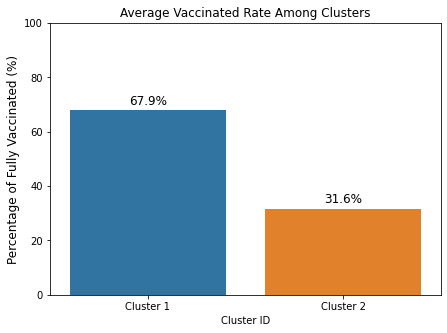

In [51]:
fig = plt.figure(figsize = (7,5))
s=sb.barplot(x='Cluster_ID',y='Vac_Rate',data=cluster_pop_avg)
plt.bar_label(s.containers[0], fmt='%.1f%%', padding=3, fontsize=12)
plt.xlabel('Cluster ID', fontsize=10)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Average Vaccinated Rate Among Clusters')
plt.ylim(0, 100)
plt.show()

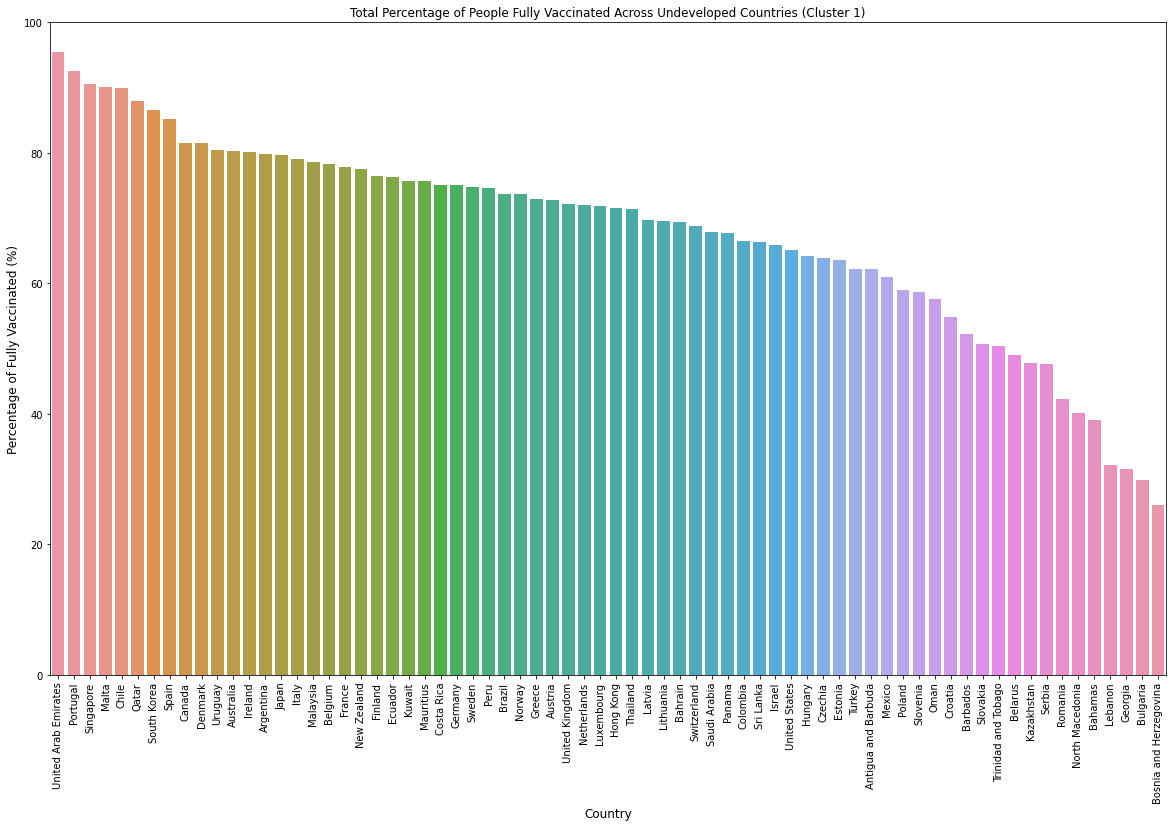

In [52]:
# Plot vaccination data for countries in cluster
fig = plt.figure(figsize = (20,12))
s=sb.barplot(x='location',y='vac_pop_percentage',data=cluster1_pop.sort_values("vac_pop_percentage", ascending=False))
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Total Percentage of People Fully Vaccinated Across Undeveloped Countries (Cluster 1)')
plt.ylim(0, 100)
plt.show()

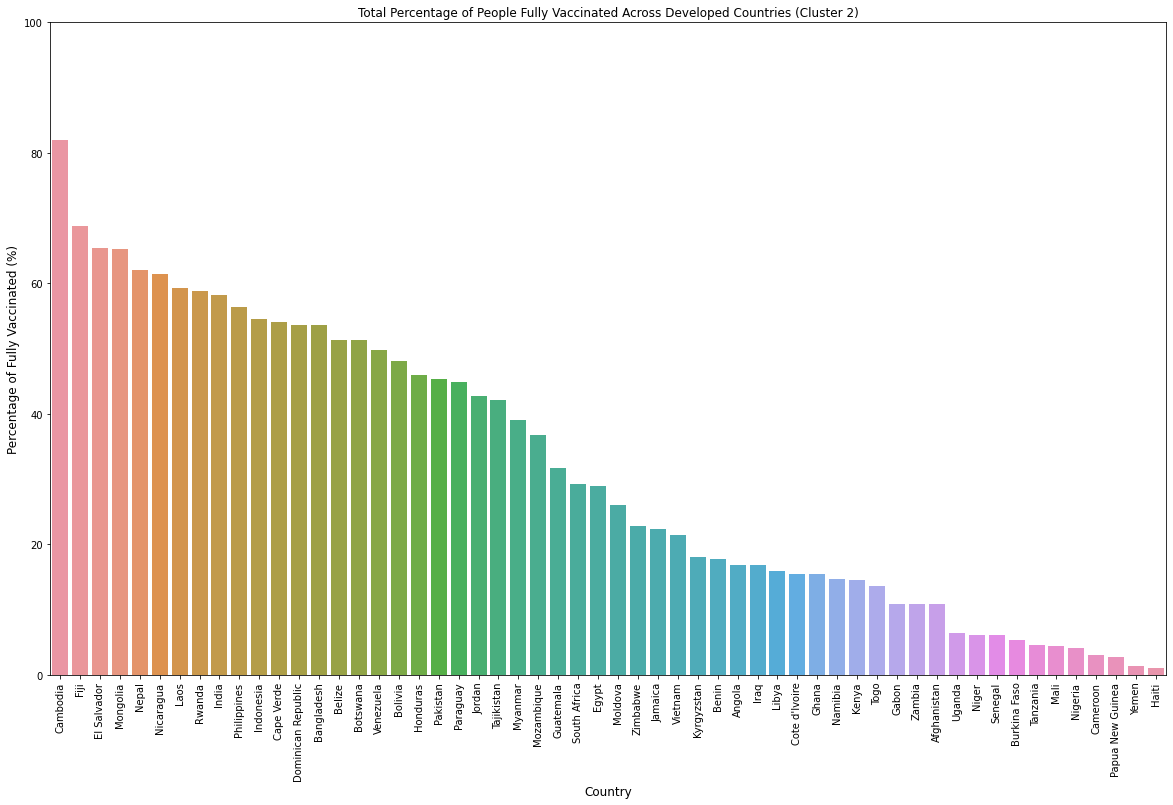

In [53]:
# Plot vaccination data for countries in cluster
fig = plt.figure(figsize = (20,12))
s=sb.barplot(x='location',y='vac_pop_percentage',data=cluster2_pop.sort_values("vac_pop_percentage", ascending=False))
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Total Percentage of People Fully Vaccinated Across Developed Countries (Cluster 2)')
plt.ylim(0, 100)
plt.show()

## New COVID-19 cases among clusters

In [54]:
cluster1_cases = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_cases.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,ATG,North America,Antigua and Barbuda,2020-03-13,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.429,8.286,0.500,-0.286,4.000,3.714
1,ATG,North America,Antigua and Barbuda,2020-03-14,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.286,7.714,1.167,-2.571,2.714,2.857
2,ATG,North America,Antigua and Barbuda,2020-03-15,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,ATG,North America,Antigua and Barbuda,2020-03-16,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,ATG,North America,Antigua and Barbuda,2020-03-17,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.429,4.286,4.167,-8.000,-4.286,-3.429


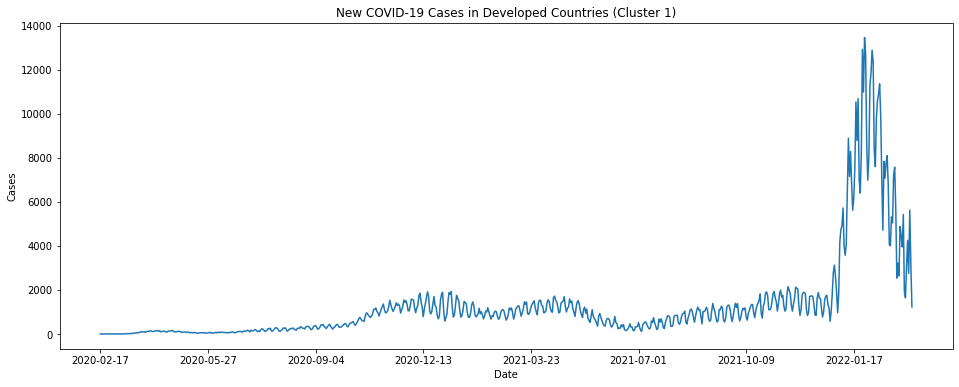

In [55]:
cluster1_cases_g = pd.DataFrame(data = cluster1_cases[["new_cases", "date"]].groupby(cluster1_cases["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster1_cases_g["new_cases"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("New COVID-19 Cases in Developed Countries (Cluster 1)");

In [56]:
cluster2_cases = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_cases.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


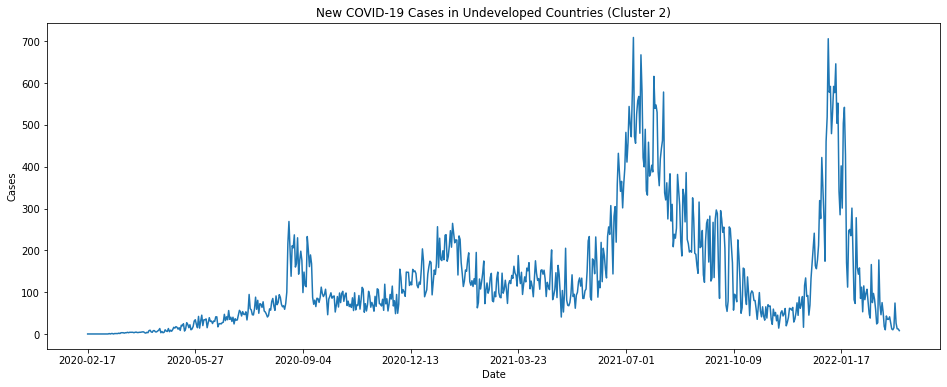

In [57]:
cluster2_cases_g = pd.DataFrame(data = cluster2_cases[["new_cases", "total_deaths"]].groupby(cluster2_cases["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster2_cases_g["new_cases"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("New COVID-19 Cases in Undeveloped Countries (Cluster 2)");

We can observe the difference in new COVID-19 cases among each clusters with cluster 2 having more spikes and disparity whilst the new cases in cluster 1 are mostly stagnant.
- The highest peak of new COVID-19 cases for cluster 1 was in January 2022.
- The highest peak of new COVID-19 cases for cluster 2 is similiar to cluster 1 with addition of July 2021.

## Total cases of COVID-19 across clusters

In [58]:
cluster1_tcases = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])[['location', 'date', 'total_cases']]
cluster1_tcases.dropna()
cluster1_tcases.head()

,location,date,total_cases
0,Antigua and Barbuda,2020-03-13,1.0
1,Antigua and Barbuda,2020-03-14,1.0
2,Antigua and Barbuda,2020-03-15,1.0
3,Antigua and Barbuda,2020-03-16,1.0
4,Antigua and Barbuda,2020-03-17,1.0


In [59]:
cluster2_tcases = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])[['location', 'date', 'total_cases']]
cluster2_tcases.dropna()
cluster2_tcases.head()

,location,date,total_cases
0,Afghanistan,2020-02-24,5.0
1,Afghanistan,2020-02-25,5.0
2,Afghanistan,2020-02-26,5.0
3,Afghanistan,2020-02-27,5.0
4,Afghanistan,2020-02-28,5.0


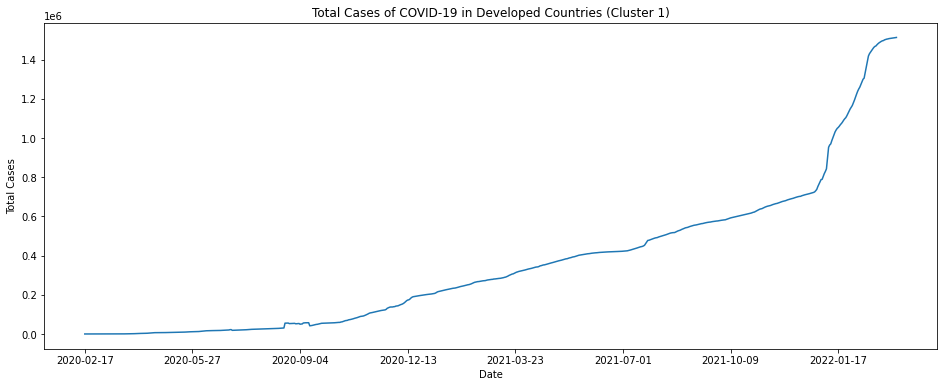

In [61]:
cluster_tcases1_g = pd.DataFrame(data = cluster1_tcases.groupby(cluster1_tcases["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster_tcases1_g["total_cases"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.title("Total Cases of COVID-19 in Developed Countries (Cluster 1)");

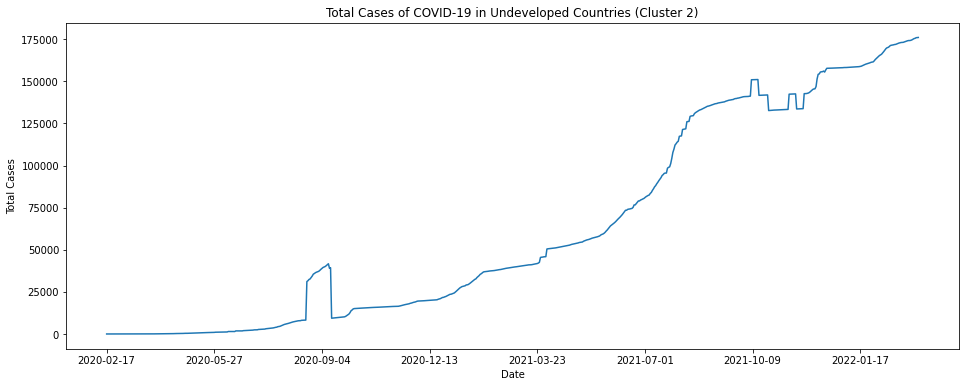

In [62]:
cluster_tcases2_g = pd.DataFrame(data = cluster2_tcases.groupby(cluster2_tcases["date"]).median())
f = plt.figure(figsize=(16, 6))
cluster_tcases2_g["total_cases"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.title("Total Cases of COVID-19 in Undeveloped Countries (Cluster 2)");

Disparity of data among certain dates when there is a drop in total COVID-19 cases (not impossible to have decrease in COVID-19 cases).

Data might be inaccurate among these dates:
- Cluster 1: September, 2020
- Cluster 2: September, 2020 and September 2021 - November 2021

## Average mobility across each clusters

In [63]:
cluster1_data = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,ATG,North America,Antigua and Barbuda,2020-03-13,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.429,8.286,0.500,-0.286,4.000,3.714
1,ATG,North America,Antigua and Barbuda,2020-03-14,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.286,7.714,1.167,-2.571,2.714,2.857
2,ATG,North America,Antigua and Barbuda,2020-03-15,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,ATG,North America,Antigua and Barbuda,2020-03-16,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,ATG,North America,Antigua and Barbuda,2020-03-17,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.429,4.286,4.167,-8.000,-4.286,-3.429


In [64]:
cluster2_data = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


In [65]:
retail_c1 = cluster1_data['retail_and_recreation'].mean()
grocery_c1 = cluster1_data['grocery_and_pharmacy'].mean()
residential_c1 = cluster1_data['residential'].mean()
transit_c1 = cluster1_data['transit_stations'].mean()
parks_c1 = cluster1_data['parks'].mean()
workplaces_c1 = cluster1_data['workplaces'].mean()

retail_c2 = cluster2_data['retail_and_recreation'].mean()
grocery_c2 = cluster2_data['grocery_and_pharmacy'].mean()
residential_c2 = cluster2_data['residential'].mean()
transit_c2 = cluster2_data['transit_stations'].mean()
parks_c2 = cluster2_data['parks'].mean()
workplaces_c2 = cluster2_data['workplaces'].mean()

cluster_a_mobility = pd.DataFrame({'Location':['Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces',
                                              'Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces'], 
                                'Average Mobility':[retail_c1, grocery_c1, residential_c1, transit_c1, parks_c1, workplaces_c1,
                                                   retail_c2, grocery_c2, residential_c2, transit_c2, parks_c2, workplaces_c2],
                                'Cluster':['1', '1', '1', '1', '1', '1',
                                          '2', '2', '2', '2', '2', '2']})
cluster_a_mobility.head(11)

,Location,Average Mobility,Cluster
0,Retail,-18.582049,1
1,Grocery,3.714593,1
2,Residential,7.067497,1
3,Transit,-24.705196,1
4,Parks,13.706085,1
5,Workplaces,-20.681746,1
6,Retail,-2.020971,2
7,Grocery,19.541519,2
8,Residential,6.299733,2
9,Transit,-8.149119,2


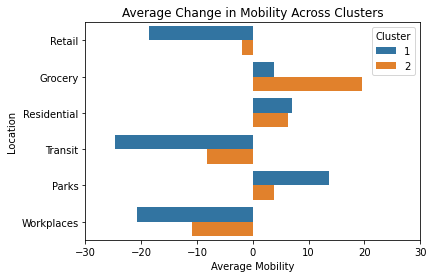

In [66]:
sb.barplot(x='Average Mobility', y='Location', hue='Cluster', data=cluster_a_mobility, orient='h')
plt.title('Average Change in Mobility Across Clusters')
plt.xlim(-30, 30)
plt.show()

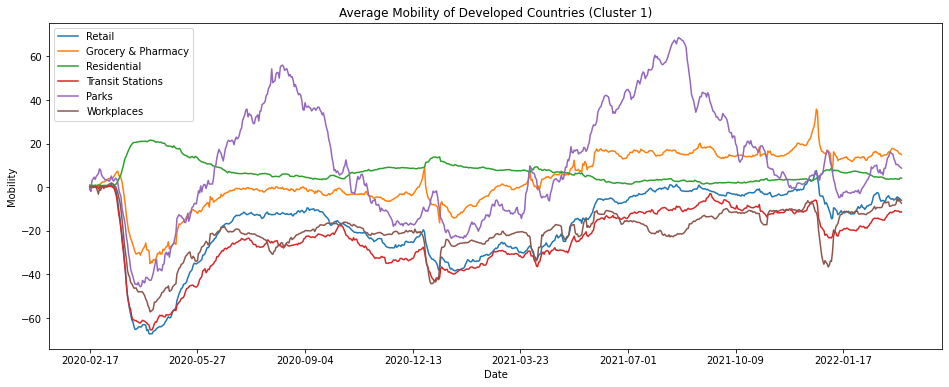

In [67]:
mobility_trend_c1 = pd.DataFrame(data = cluster1_data[["retail_and_recreation", "grocery_and_pharmacy", "residential", 
                                        "transit_stations", "parks", "workplaces"]].groupby(cluster1_data["date"]).median())
f = plt.figure(figsize=(16, 6))
mobility_trend_c1["retail_and_recreation"].plot(kind = "line", label="Retail");
mobility_trend_c1["grocery_and_pharmacy"].plot(kind = "line", label="Grocery & Pharmacy");
mobility_trend_c1["residential"].plot(kind = "line", label="Residential");
mobility_trend_c1["transit_stations"].plot(kind = "line", label="Transit Stations");
mobility_trend_c1["parks"].plot(kind = "line", label="Parks");
mobility_trend_c1["workplaces"].plot(kind = "line", label="Workplaces");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Mobility")
plt.title("Average Mobility of Developed Countries (Cluster 1)");

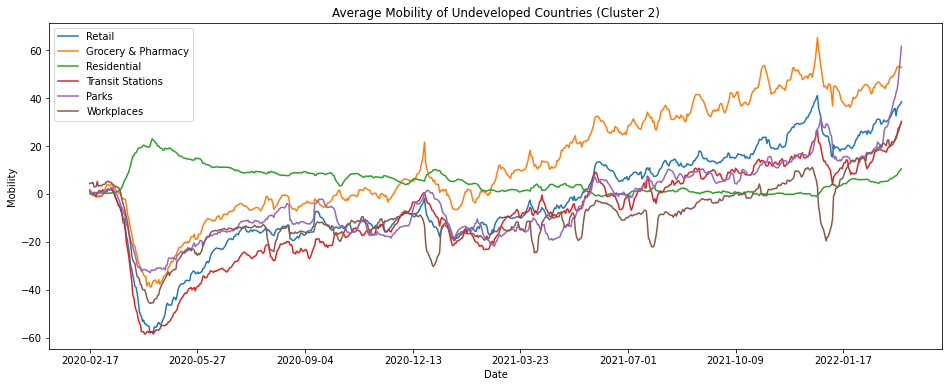

In [68]:
mobility_trend_c2 = pd.DataFrame(data = cluster2_data[["retail_and_recreation", "grocery_and_pharmacy", "residential", 
                                        "transit_stations", "parks", "workplaces"]].groupby(cluster2_data["date"]).median())
f = plt.figure(figsize=(16, 6))
mobility_trend_c2["retail_and_recreation"].plot(kind = "line", label="Retail");
mobility_trend_c2["grocery_and_pharmacy"].plot(kind = "line", label="Grocery & Pharmacy");
mobility_trend_c2["residential"].plot(kind = "line", label="Residential");
mobility_trend_c2["transit_stations"].plot(kind = "line", label="Transit Stations");
mobility_trend_c2["parks"].plot(kind = "line", label="Parks");
mobility_trend_c2["workplaces"].plot(kind = "line", label="Workplaces");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Mobility")
plt.title("Average Mobility of Undeveloped Countries (Cluster 2)");

We can observe that the average mobility influctuates over time with some drastic changes during some intervals during COVID-19. Mobility across each clusters are also trends differently (except residential).

## Finding the best regression model for prediction
- Scale data using MinMaxScaler
- Run data in each cluster through 5 different regression models (Linear Regression, Support Vector Regression, Stochastic Gradient Descent, Decision Tree Regressor, MLP Regression)

In [69]:
cluster1_regression = cluster1_data[relevant_columns]
cluster1_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,people_fully_vaccinated,new_cases,aged_70_older,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,NaN,NaN,1.0,NaN,1.0,4.631,1.429,8.286,0.500,-0.286,4.000,3.714
1,NaN,NaN,1.0,NaN,0.0,4.631,-0.286,7.714,1.167,-2.571,2.714,2.857
2,NaN,NaN,1.0,NaN,0.0,4.631,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,NaN,NaN,1.0,NaN,0.0,4.631,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,NaN,NaN,1.0,NaN,0.0,4.631,-7.429,4.286,4.167,-8.000,-4.286,-3.429


In [70]:
cluster2_regression = cluster2_data[relevant_columns]
cluster2_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,people_fully_vaccinated,new_cases,aged_70_older,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,NaN,NaN,5.0,NaN,5.0,1.337,1.000,6.286,0.286,6.143,2.714,6.000
1,NaN,NaN,5.0,NaN,0.0,1.337,0.857,6.286,0.429,6.143,2.429,6.143
2,NaN,NaN,5.0,NaN,0.0,1.337,0.857,6.571,0.429,6.571,2.571,6.143
3,NaN,NaN,5.0,NaN,0.0,1.337,1.000,6.143,0.571,6.429,2.857,6.286
4,NaN,NaN,5.0,NaN,0.0,1.337,0.714,5.571,0.857,6.000,2.429,6.143


In [71]:
scaler = MinMaxScaler()
cluster1_regression = cluster1_regression.fillna(0)
cluster1_regression = pd.DataFrame(scaler.fit_transform(cluster1_regression), columns = cluster1_regression.columns)
cluster1_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,people_fully_vaccinated,new_cases,aged_70_older,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,0.0,0.0,1.257629e-08,0.0,7.235262e-07,0.250419,0.601477,0.519188,0.275129,0.551246,0.140514,0.735505
1,0.0,0.0,1.257629e-08,0.0,0.000000e+00,0.250419,0.590403,0.516053,0.286860,0.537469,0.138646,0.728260
2,0.0,0.0,1.257629e-08,0.0,0.000000e+00,0.250419,0.576564,0.512923,0.286860,0.526267,0.133873,0.718597
3,0.0,0.0,1.257629e-08,0.0,0.000000e+00,0.250419,0.566419,0.505874,0.310305,0.520237,0.132005,0.698071
4,0.0,0.0,1.257629e-08,0.0,0.000000e+00,0.250419,0.544276,0.497262,0.339624,0.504736,0.128476,0.675118


<AxesSubplot:>

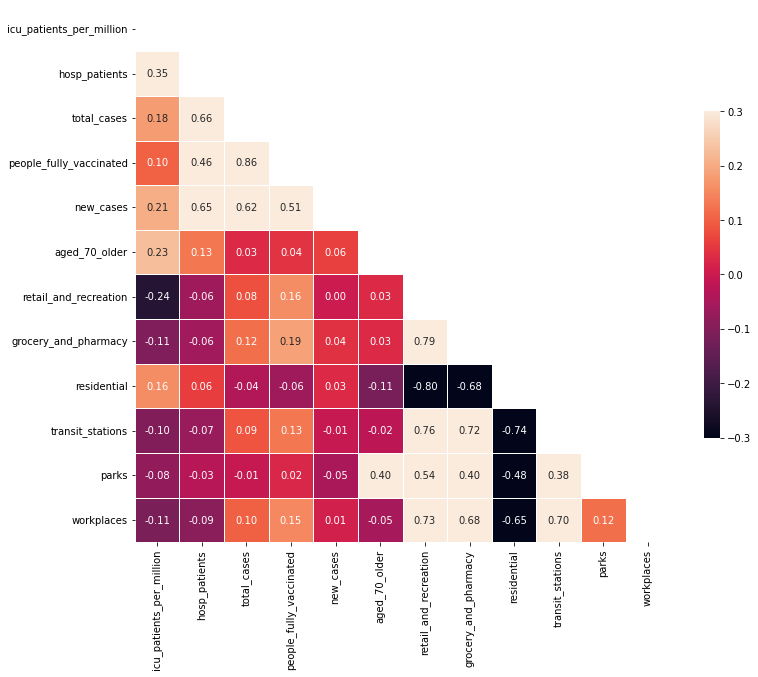

In [72]:
var_corr1 = cluster1_regression.corr()

mask = np.triu(np.ones_like(var_corr1, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

sb.heatmap(var_corr1, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

<AxesSubplot:>

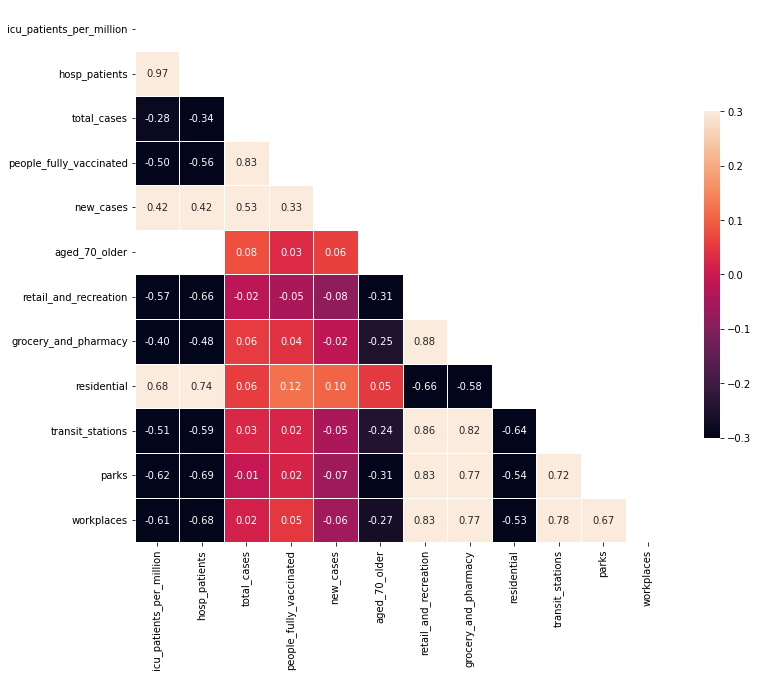

In [73]:
var_corr2 = cluster2_regression.corr()

mask = np.triu(np.ones_like(var_corr2, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

sb.heatmap(var_corr2, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

From the heatmap we can observe that each variable affect mobility with a slight difference in both clusters

In [74]:
y_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']
x_data = cluster1_regression.drop(y_columns, axis=1)
x_columns = x_data.columns.tolist()
print(x_columns)

['icu_patients_per_million', 'hosp_patients', 'total_cases', 'people_fully_vaccinated', 'new_cases', 'aged_70_older']


In [75]:
models = [LinearRegression(), svm.SVR(), SGDRegressor(), tree.DecisionTreeRegressor() , MLPRegressor(random_state=1, max_iter=500)]
x = cluster1_regression[x_columns]
for i in range(len(y_columns)):
#     print(y_columns[i])
    y = cluster1_regression[y_columns[i]]
    print(x.shape,y.shape)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    for m in models:
        print()
        print(y_columns[i],m)
        model = m
        model.fit(x_train, y_train)

        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print("r2 score is =", score)
        print("mean_sqrd_error is =",mean_squared_error(y_test,y_prediction))
        print("root_mean_squared error of is =",np.sqrt(mean_squared_error(y_test,y_prediction)))

(51960, 6) (51960,)

retail_and_recreation LinearRegression()
r2 score is = 0.10143015090206065
mean_sqrd_error is = 0.018530358759100068
root_mean_squared error of is = 0.1361262603581692

retail_and_recreation SVR()
r2 score is = 0.2610695553677067
mean_sqrd_error is = 0.01523826584077305
root_mean_squared error of is = 0.12344337098756275

retail_and_recreation SGDRegressor()
r2 score is = 0.0934154006211032
mean_sqrd_error is = 0.018695639397238364
root_mean_squared error of is = 0.13673199843942296

retail_and_recreation DecisionTreeRegressor()
r2 score is = 0.9467403033693598
mean_sqrd_error is = 0.001098324506389071
root_mean_squared error of is = 0.03314097926116655

retail_and_recreation MLPRegressor(max_iter=500, random_state=1)
r2 score is = 0.2928643070918403
mean_sqrd_error is = 0.014582592654435707
root_mean_squared error of is = 0.12075840614398531
(51960, 6) (51960,)

grocery_and_pharmacy LinearRegression()
r2 score is = 0.06521295820673367
mean_sqrd_error is = 0.011238

In [76]:
scaler = MinMaxScaler()
cluster2_regression = cluster2_regression.fillna(0)
cluster2_regression = pd.DataFrame(scaler.fit_transform(cluster2_regression), columns = cluster2_regression.columns)
cluster2_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,people_fully_vaccinated,new_cases,aged_70_older,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,0.0,0.0,1.163034e-07,0.0,0.000012,0.005135,0.339480,0.298363,0.355897,0.399173,0.248343,0.447032
1,0.0,0.0,1.163034e-07,0.0,0.000000,0.005135,0.338938,0.298363,0.358083,0.399173,0.247565,0.447784
2,0.0,0.0,1.163034e-07,0.0,0.000000,0.005135,0.338938,0.299246,0.358083,0.400945,0.247953,0.447784
3,0.0,0.0,1.163034e-07,0.0,0.000000,0.005135,0.339480,0.297920,0.360253,0.400357,0.248733,0.448536
4,0.0,0.0,1.163034e-07,0.0,0.000000,0.005135,0.338395,0.296148,0.364624,0.398581,0.247565,0.447784


In [77]:
y_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']
x_data = cluster2_regression.drop(y_columns, axis=1)
x_columns = x_data.columns.tolist()
print(x_columns)

['icu_patients_per_million', 'hosp_patients', 'total_cases', 'people_fully_vaccinated', 'new_cases', 'aged_70_older']


In [78]:
models = [LinearRegression(), svm.SVR(), SGDRegressor(), tree.DecisionTreeRegressor() , MLPRegressor(random_state=1, max_iter=500)]
x = cluster2_regression[x_columns]
for i in range(len(y_columns)):
#     print(y_columns[i])
    y = cluster2_regression[y_columns[i]]
    print(x.shape,y.shape)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    for m in models:
        print()
        print(y_columns[i],m)
        model = m
        model.fit(x_train, y_train)

        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print("r2 score is =", score)
        print("mean_sqrd_error is =",mean_squared_error(y_test,y_prediction))
        print("root_mean_squared error of is =",np.sqrt(mean_squared_error(y_test,y_prediction)))

(40351, 6) (40351,)

retail_and_recreation LinearRegression()
r2 score is = 0.09957192827941286
mean_sqrd_error is = 0.014552607667221613
root_mean_squared error of is = 0.12063418946228144

retail_and_recreation SVR()
r2 score is = 0.258132899483706
mean_sqrd_error is = 0.011989964766872615
root_mean_squared error of is = 0.10949869755788247

retail_and_recreation SGDRegressor()
r2 score is = 0.09065481332149183
mean_sqrd_error is = 0.014696724981620944
root_mean_squared error of is = 0.12123004982932632

retail_and_recreation DecisionTreeRegressor()
r2 score is = 0.9670930662826903
mean_sqrd_error is = 0.0005318378124353679
root_mean_squared error of is = 0.02306160905998035

retail_and_recreation MLPRegressor(max_iter=500, random_state=1)
r2 score is = 0.2569986819900778
mean_sqrd_error is = 0.012008295850401064
root_mean_squared error of is = 0.10958237016236264
(40351, 6) (40351,)

grocery_and_pharmacy LinearRegression()
r2 score is = 0.06811795510306207
mean_sqrd_error is = 0.015

#### Looking at the results of R2 score for all models, Decision Tree Regressor is the best.
- Best model for cluster 1: Decision Tree Regressor
- Best model for cluster 2: Decision Tree Regressor

## Conclusion
- As the average mobility for each country differs, clustering is needed to group similar country together. The optimal cluster for countries after performing EDA is 2. Developed country and Undeveloped country.
- Mobility among retail, transit station and workplaces has been affected the most during COVID-19. However, for countries in cluster 2, mobility in grocery place have increased drastically instead.
- Both clusters have different influctuation of COVID-19 cases. COVID-19 cases in cluster 1 are mostly stable while cluster 2 spikes frequently. The vaccination rate is also very different for both clusters.
- Mobility in both clusters are affected by different variable hence it crucial to cluster the countries first before performing regression if high accuracy is preferred!
- Prediction of mobility can be done using Decision Tree Regressor model and the accuracy is at least 90% for both clusters!
